In [18]:
import torch 
import torch.nn as nn 
from torch.nn import functional as F 
import matplotlib.pyplot as plt 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
block_size = 64
batch_size = 128
max_iters = 3000
learning_rate = 3e-4
eval_iters = 100
eval_interval = 500
n_embd = 384
n_head = 8
n_layers = 8
dropout = 0.2

In [3]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias = False)
        self.query = nn.Linear(n_embd, head_size, bias = False)
        self.value = nn.Linear(n_embd, head_size, bias = False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim = -1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v

        return out

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.dropout(self.proj(out))
        return out 

In [5]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

In [6]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x) 
        x = self.ln2(x + y)
        return x

In [7]:
class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        self.blocks = nn.Sequential(*[Block(n_embd, n_head = n_head) for _ in range(n_layers)])

        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear): 
            torch.nn.init.normal_(module.weight, mean = 0.0, std = 0.02)
            if module.bias is not None: 
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = 0.02)

    def forward(self, index, targets = None):
        B, T = index.shape
        token_embeddings = self.token_embedding_table(index)
        position_embeddings = self.position_embedding_table(torch.arange(T, device = device))
        x = token_embeddings + position_embeddings
        x = self.blocks(x) 
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None: 
            loss = None
        else: 
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, index, max_new_tokens): 
        for _ in range(max_new_tokens):
            logits, loss = self.forward(index)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim = -1)
            index_next = torch.multinomial(probs, num_samples = 1)
            index = torch.cat((index, index_next), dim = 1)
        return index

In [8]:
chars = None
with open('./data/shakespeare.txt', 'r', encoding='utf-8') as f: 
    text = f.read()
    chars = sorted(list(set(text)))
vocab_size = len(chars)

In [9]:
string_to_int = { ch:i for i, ch in enumerate(chars) }
int_to_string = { i:ch for i, ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: "".join([int_to_string[i] for i in l])

In [10]:
data = torch.tensor(encode(text), dtype = torch.long)

In [11]:
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

In [12]:
def get_batch(split): 
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i + block_size] for i in ix])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    
    return x, y

In [13]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [14]:
model = GPTLanguageModel(vocab_size)
model = model.to(device)

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_list = []
for iteration in range(max_iters):
    if iteration % eval_iters == 0: 
        losses = estimate_loss()
        print(f"Step: {iteration}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")
    
    xb, yb = get_batch('train')

    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()
    loss_list.append(float(loss))
print(loss.item())

Step: 0, train loss: 4.748, val loss: 4.747
Step: 100, train loss: 2.392, val loss: 2.416
Step: 200, train loss: 2.074, val loss: 2.103
Step: 300, train loss: 1.900, val loss: 1.944
Step: 400, train loss: 1.797, val loss: 1.852
Step: 500, train loss: 1.722, val loss: 1.794
Step: 600, train loss: 1.654, val loss: 1.743
Step: 700, train loss: 1.609, val loss: 1.709
Step: 800, train loss: 1.566, val loss: 1.685
Step: 900, train loss: 1.538, val loss: 1.666
Step: 1000, train loss: 1.509, val loss: 1.648
Step: 1100, train loss: 1.488, val loss: 1.631
Step: 1200, train loss: 1.467, val loss: 1.617
Step: 1300, train loss: 1.456, val loss: 1.613
Step: 1400, train loss: 1.432, val loss: 1.593
Step: 1500, train loss: 1.419, val loss: 1.588
Step: 1600, train loss: 1.415, val loss: 1.585
Step: 1700, train loss: 1.399, val loss: 1.577
Step: 1800, train loss: 1.392, val loss: 1.570
Step: 1900, train loss: 1.381, val loss: 1.561
Step: 2000, train loss: 1.376, val loss: 1.553
Step: 2100, train loss: 1

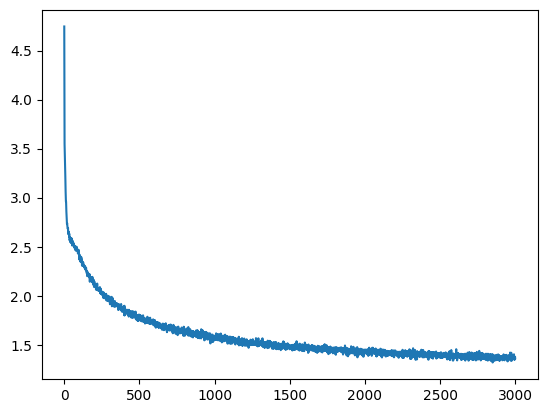

In [19]:
plt.plot(loss_list)
plt.show()